#ENTREGABLE GRUPO 16
##INTEGRANTES:
Fernanda Borghello, Rodrigo Ruiz, Alfonsina Szpeiner
###Laboratorio 2: Armado de un esquema de aprendizaje automático

# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [1]:
#Para carga del dataset
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
#Gráficos y cálculos
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Transformaciones
from sklearn.preprocessing import StandardScaler
#Modelos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
#Selección de modelos
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
#Métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report
#Arbol de decisión
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn import tree

## Funciones

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta correcta')
    plt.xlabel('Etiqueta predicha')

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [3]:
def connect_to_drive():
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    return GoogleDrive(gauth)

def read_csv_from_drive(drive, id, filename):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(filename)  
    return pd.read_csv(filename, comment="#")

drive = connect_to_drive()
dataset = read_csv_from_drive(drive, '1wA-Ns7CyS5TRFwZr4LugVXsAk14UAYBS' , 'loan_data.csv')

In [4]:
#dataset = pd.read_csv("./data/loan_data.csv", comment="#")

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
dataset.sample(10)

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
1490,0,12900,56798.0,71364.0,1.0,0.0,0.0,225.585763,0.0,9.0,33.021284
990,0,14400,89605.0,106290.0,20.0,0.0,0.0,121.747601,4.0,24.0,29.303549
1760,1,20800,176235.0,209695.0,9.0,3.0,0.0,159.706770,0.0,25.0,38.591940
497,0,49300,40724.0,102546.0,6.0,0.0,0.0,211.449314,1.0,36.0,39.037679
1414,0,9700,59633.0,70398.0,4.0,0.0,0.0,239.038206,1.0,16.0,38.867249
1767,1,21200,69212.0,106273.0,12.0,0.0,1.0,97.231123,0.0,22.0,18.114896
415,0,22100,45993.0,67208.0,8.0,0.0,1.0,60.457005,2.0,18.0,34.780920
1229,0,12500,56960.0,69014.0,4.0,0.0,0.0,307.636664,0.0,10.0,30.362484
1803,1,26600,84843.0,115850.0,2.0,0.0,0.0,137.538878,2.0,37.0,42.571890
1640,1,12000,54257.0,82764.0,14.0,1.0,1.0,188.337422,2.0,31.0,38.942760



Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [6]:
dataset.shape

(1854, 11)

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

**No hace falta escribir código para responder estas preguntas.**

<font color='red'><strong>
1) El cojunto de datos está integrado por 1854 registros con 11 variables, cuyos datos fueron recogidas a partir de las solicitudes de préstamos aprobadas para una línea de créditos hipotecarios, según el actual procedimiento para la evaluación y aprobación de estos créditos.<br>

<font color='Mediumblue'><strong>
2) La variable objetivo es una variable binaria que indica si la persona que solicitó el préstamo incumplió en los pagos (target = 1) o devolvió todo el crédito (target = 0).<br>

<font color='red'><strong>
3) El conjunto de datos cuenta con 10 variables que se pueden utilizar para la construcción del modelo de predicción. Estas variables son:<br>
- LOAN: monto solicitado del préstamo
- MORTDUE: monto adeudado de la hipoteca existente
- VALUE: valor de la propiedad actual
- YOJ: antigüedad en años en el trabajo actual
- DEROG: cantidad de reportes degradatorios importantes (reportes que indican pagos no realizados, embargos y ejecuciones hipotecarias)
- DELINQ: cantidad de líneas de crédito morosas (una lína de crédito se considera morosa cuando no se realizan los pagos mínimos dentro de 30 a 60 días posteriores a la fecha exigida)
- CLAGE: antigüedad del registro crediticio más antiguo en meses. Se trata de un registro de actividad para cualquier tipo de crédito concedido a un prestatario y comunicado a una agencia de información crediticia.
- NINQ: cantidad de líneas de crédito recientes
- CLNO: cantidad de líneas de crédito
- DEBTINC: relación deuda/ingresos
<br>

<font color='Mediumblue'><strong>
4) Considerando los factores que se tienen en cuenta para calcular el score crediticio de una persona, los atributos más determinantes para la predicción podrían ser LOAN, DEROG, DELINQ, CLAGE, NINQ y DEBTINC.

<font color='blue'><strong>
Para confirmar lo supuesto, realizamos una matriz de correlación 

Text(0.5, 1.0, 'Correlation between Variables')

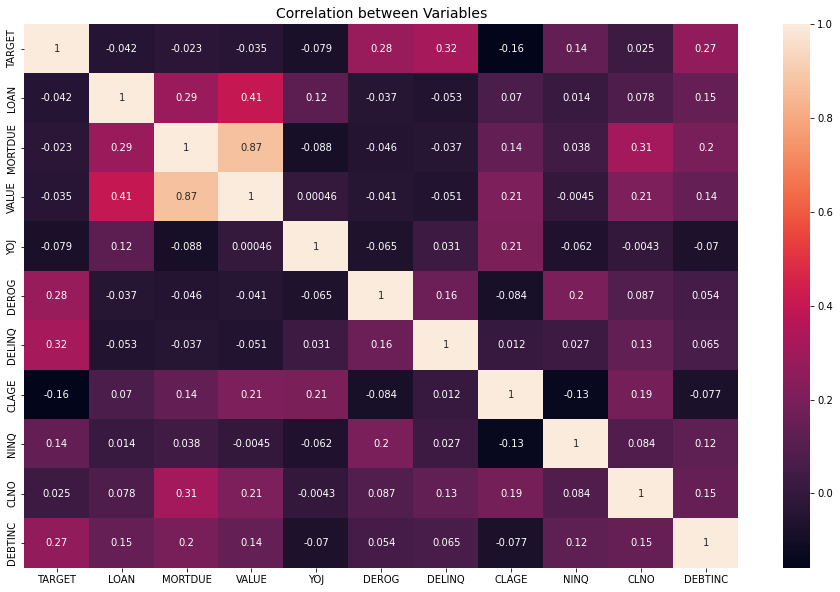

In [7]:
plt.figure(figsize=(16,10))
sns.heatmap(dataset[dataset.columns].corr(),annot=True, fmt='.2g')
plt.title('Correlation between Variables', fontsize=14)

<font color='Mediumblue'><strong>
Analizando la Matriz de Correlación, los atributos disponibles que pueden ser mas determinantes para la predicción, son:<br>

- DELINQ: número de líneas de crédito morosas
- DEROG: número de informes despectivos importantes.
- DEBTINC: Relación deuda-ingresos
- CLAGE: Antigüedad de la línea comercial más antigua en meses
- NINQ: Número de líneas de crédito recientes

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

<font color='MediumBlue'><strong>
Previo a entrenar el modelo, es necesario escalar los datos ya que el decenso de gradiente estocástico es a la escala de las características que se utilizarán.

In [8]:
#Escalado de los datos
scaler = StandardScaler()
scaler.fit(X_train)  # Sólo se entrena con el set de entrenamiento
X_train_slcd = scaler.transform(X_train)
X_test_slcd = scaler.transform(X_test)  # Se aplica la misma transformación al set de prueba

In [9]:
#Entrenamiento del modelo
clf_SGD_1 = SGDClassifier(random_state=0)
clf_SGD_1.fit(X_train_slcd,y_train)
y_test_pred_SGD_1 = clf_SGD_1.predict(X_test_slcd)
y_test_pred_SGD_1

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

<font color='MediumBlue'><strong>
EVALUACION CON METRICAS DEL CONJUNTO DE ENTRENAMIENTO

In [10]:
y_train_pred_SGD_1 = clf_SGD_1.predict(X_train_slcd)
print(classification_report(y_train, y_train_pred_SGD_1))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1232
           1       0.71      0.42      0.53       251

    accuracy                           0.87      1483
   macro avg       0.80      0.69      0.73      1483
weighted avg       0.86      0.87      0.86      1483



<font color='MediumBlue'><strong>
MATRIZ DE CONFUSIÓN PARA EL CONJUNTO DE ENTRENAMIENTO

In [11]:
cm=confusion_matrix(y_train, y_train_pred_SGD_1)
cm

array([[1190,   42],
       [ 146,  105]])

[Text(30.5, 0.5, 'Etiqueta predicha'), Text(0.5, 21.5, 'Etiqueta correcta')]

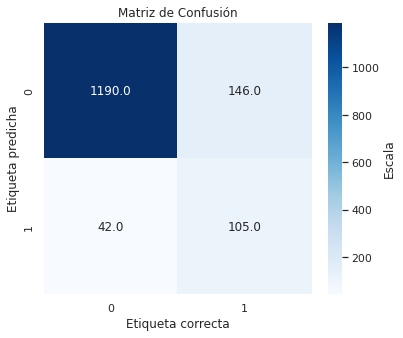

In [12]:
sns.set(color_codes=True)
plt.figure(1, figsize=(6, 5))

plt.title("Matriz de Confusión" )
# define labels
labels = ["0", "1"] 
sns.set(font_scale=1)
ax = sns.heatmap(cm.T, annot=True, fmt='.1f', cmap="Blues", cbar_kws={'label': 'Escala'})
 
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
 
ax.set(ylabel="Etiqueta predicha", xlabel="Etiqueta correcta")

<font color='MediumBlue'><strong>
EVALUACION CON METRICAS DEL CONJUNTO DE EVALUACIÓN

In [13]:
print(classification_report(y_test, y_test_pred_SGD_1))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       313
           1       0.65      0.34      0.45        58

    accuracy                           0.87       371
   macro avg       0.77      0.65      0.69       371
weighted avg       0.85      0.87      0.85       371



<font color='MediumBlue'><strong>
MATRIZ DE CONFUSIÓN PARA EL CONJUNTO DE EVALUACIÓN

In [14]:
cm2=confusion_matrix(y_test, y_test_pred_SGD_1)
cm2

array([[302,  11],
       [ 38,  20]])

[Text(30.5, 0.5, 'Etiqueta predicha'), Text(0.5, 21.5, 'Etiqueta correcta')]

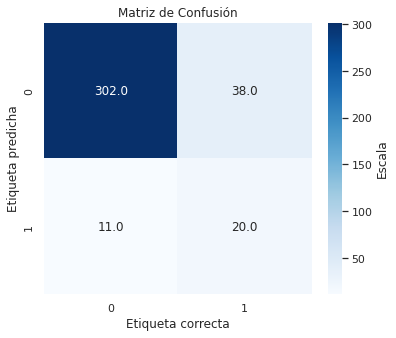

In [15]:
sns.set(color_codes=True)
plt.figure(1, figsize=(6, 5))

plt.title("Matriz de Confusión" )
# define labels
labels = ["0", "1"] 
sns.set(font_scale=1)
ax = sns.heatmap(cm2.T, annot=True, fmt='.1f', cmap="Blues", cbar_kws={'label': 'Escala'})
 
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
 
ax.set(ylabel="Etiqueta predicha", xlabel="Etiqueta correcta")

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [16]:
#para probar escalando los datos previamente
scaling  = True #True / False

if scaling:
    #Escalado de los datos
    scaler = StandardScaler()
    scaler.fit(X)
    X_slcd = scaler.transform(X)
    X = X_slcd

In [17]:
#Se transforma el dataframe de pandas en un array
X_arr = np.array(X)
y_arr = np.array(y)

TARGET
0    1545
1     309
Name: TARGET, dtype: int64

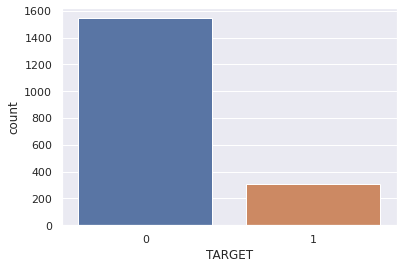

In [18]:
g = sns.countplot(x='TARGET', data=dataset)
dataset.groupby('TARGET')['TARGET'].count()

<font color='MediumBlue'><strong>
Teniendo en consideración que las clases están muy desbalanceadas (relación 5:1), se utilizará el StratifiedKFold para generar los consecutivos conjuntos de entrenamiento y prueba, y procurar que se preserve la frecuencia relativa de las clases.

In [19]:
#división K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
skf_cv = skf.split(X_arr,y_arr)

In [20]:
#Grilla de parámetros
param_grid = {
    'loss': ['hinge', 'log', 'perceptron'],   #función de pérdida
    'alpha': np.arange(0.0001,0.001,0.0001),   #tasa de regularización
    'learning_rate': ['optimal', 'invscaling', 'adaptive'],    #selección tipo tasa de entrenamiento
    'eta0': [0.5,1]  #tasa de entrenamiento inicial
}
# for params in ParameterGrid(param_grid):
#     print(params)
print(f'Combinaciones posibles: {len(ParameterGrid(param_grid))}')

Combinaciones posibles: 162


In [21]:
#Búsqueda de la mejor combinación de parámetros
modelo = SGDClassifier(random_state=0)
grid_cv = GridSearchCV(modelo, param_grid, scoring='accuracy', cv=skf_cv)
#grid_cv = GridSearchCV(modelo, param_grid, scoring='accuracy', cv=5) #equivale a skf = StratifiedKFold(n_splits=5, shuffle=False)
grid_cv.fit(X_arr,y_arr)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f4e2faa39d0>,
             estimator=SGDClassifier(random_state=0),
             param_grid={'alpha': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'eta0': [0.5, 1],
                         'learning_rate': ['optimal', 'invscaling', 'adaptive'],
                         'loss': ['hinge', 'log', 'perceptron']},
             scoring='accuracy')

In [22]:
#Resultados
resultados = pd.DataFrame(grid_cv.cv_results_)[['param_loss','param_alpha','param_learning_rate','mean_test_score','std_test_score','rank_test_score']]
resultados.rename_axis('index').sort_values(by = ['rank_test_score', 'index'], ascending = [True, True]).head(10)

,param_loss,param_alpha,param_learning_rate,mean_test_score,std_test_score,rank_test_score
index,,,,,,
75,hinge,0.0005,invscaling,0.877016,0.015171,1
120,hinge,0.0007,invscaling,0.874861,0.016699,2
57,hinge,0.0004,invscaling,0.874860,0.015065,3
159,hinge,0.0009,adaptive,0.874860,0.016624,3
12,hinge,0.0001,invscaling,0.874858,0.017068,5
96,hinge,0.0006,adaptive,0.874321,0.016534,6
114,hinge,0.0007,adaptive,0.874321,0.016534,6
150,hinge,0.0009,adaptive,0.874321,0.016534,6
6,hinge,0.0001,adaptive,0.874321,0.017138,9


In [23]:
#Mejor combinación de parámetros
best_p = grid_cv.best_params_
best_p

{'alpha': 0.0005, 'eta0': 0.5, 'learning_rate': 'invscaling', 'loss': 'hinge'}

#### Entrenamiento con los hiperparámetros seleccionados

In [24]:
#Entrenamiento del modelo
clf_SGD_2 = SGDClassifier(**best_p, random_state=0)
clf_SGD_2.fit(X_train_slcd,y_train)
y_test_pred_SGD_2 = clf_SGD_2.predict(X_test_slcd)

In [25]:
clf_SGD_2

SGDClassifier(alpha=0.0005, eta0=0.5, learning_rate='invscaling',
              random_state=0)

<font color='MediumBlue'><strong>
EVALUACION CON METRICAS DEL CONJUNTO DE ENTRENAMIENTO

In [26]:
y_train_pred_SGD_2 = clf_SGD_2.predict(X_train_slcd)
print(classification_report(y_train, y_train_pred_SGD_2))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93      1232
           1       0.86      0.29      0.43       251

    accuracy                           0.87      1483
   macro avg       0.87      0.64      0.68      1483
weighted avg       0.87      0.87      0.84      1483



<font color='MediumBlue'><strong>
MATRIZ DE CONFUSIÓN PARA EL CONJUNTO DE ENTRENAMIENTO

In [27]:
cm=confusion_matrix(y_train, y_train_pred_SGD_2)
cm

array([[1220,   12],
       [ 178,   73]])

[Text(30.5, 0.5, 'Etiqueta predicha'), Text(0.5, 21.5, 'Etiqueta correcta')]

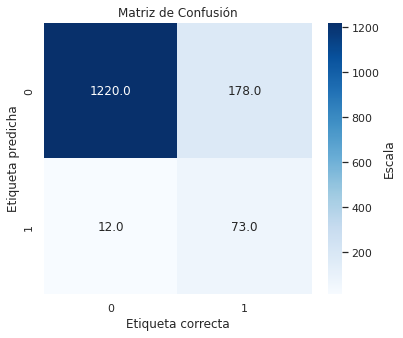

In [28]:
sns.set(color_codes=True)
plt.figure(1, figsize=(6, 5))

plt.title("Matriz de Confusión" )
# define labels
labels = ["0", "1"] 
sns.set(font_scale=1)
ax = sns.heatmap(cm.T, annot=True, fmt='.1f', cmap="Blues", cbar_kws={'label': 'Escala'})
 
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
 
ax.set(ylabel="Etiqueta predicha", xlabel="Etiqueta correcta")

<font color='MediumBlue'><strong>
EVALUACION CON METRICAS DEL CONJUNTO DE EVALUACIÓN

In [29]:
print(classification_report(y_test, y_test_pred_SGD_2))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       313
           1       0.85      0.29      0.44        58

    accuracy                           0.88       371
   macro avg       0.87      0.64      0.68       371
weighted avg       0.88      0.88      0.86       371



<font color='MediumBlue'><strong>
MATRIZ DE CONFUSIÓN PARA EL CONJUNTO DE EVALUACIÓN

In [30]:
cm2=confusion_matrix(y_test, y_test_pred_SGD_2)
cm2

array([[310,   3],
       [ 41,  17]])

[Text(30.5, 0.5, 'Etiqueta predicha'), Text(0.5, 21.5, 'Etiqueta correcta')]

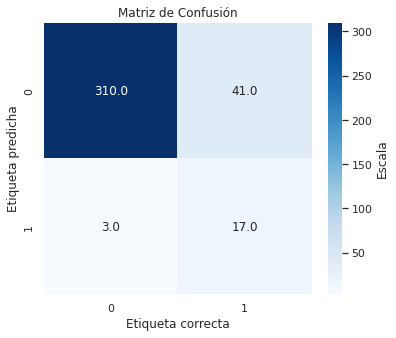

In [31]:
sns.set(color_codes=True)
plt.figure(1, figsize=(6, 5))

plt.title("Matriz de Confusión" )
# define labels
labels = ["0", "1"] 
sns.set(font_scale=1)
ax = sns.heatmap(cm2.T, annot=True, fmt='.1f', cmap="Blues", cbar_kws={'label': 'Escala'})
 
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
 
ax.set(ylabel="Etiqueta predicha", xlabel="Etiqueta correcta")

<font color='MediumBlue'><strong>
Concluímos que este último modelo, con la mejor combinación de parámetros hallada, es superior al modelo con los parámetros por defecto porque mejora la exactitud de la predicción. Siendo que en promedio mejoraron levemente todas las métricas, tomamos la exactitud como principal porque para este caso sería un problema aceptar el otorgamiento de un préstamo a alguien que no lo saldará; es decir, es muy importante ser exactos en la aprobación de las solicitudes.

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


In [32]:
#Entrenamos el modelo con parámetros por defecto
clf_TREE_1 = DecisionTreeClassifier(random_state=0)
clf_TREE_1.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [33]:
#Predecimos y evaluamos
y_train_pred_TREE_1 = clf_TREE_1.predict(X_train)
y_test_pred_TREE_1 = clf_TREE_1.predict(X_test)

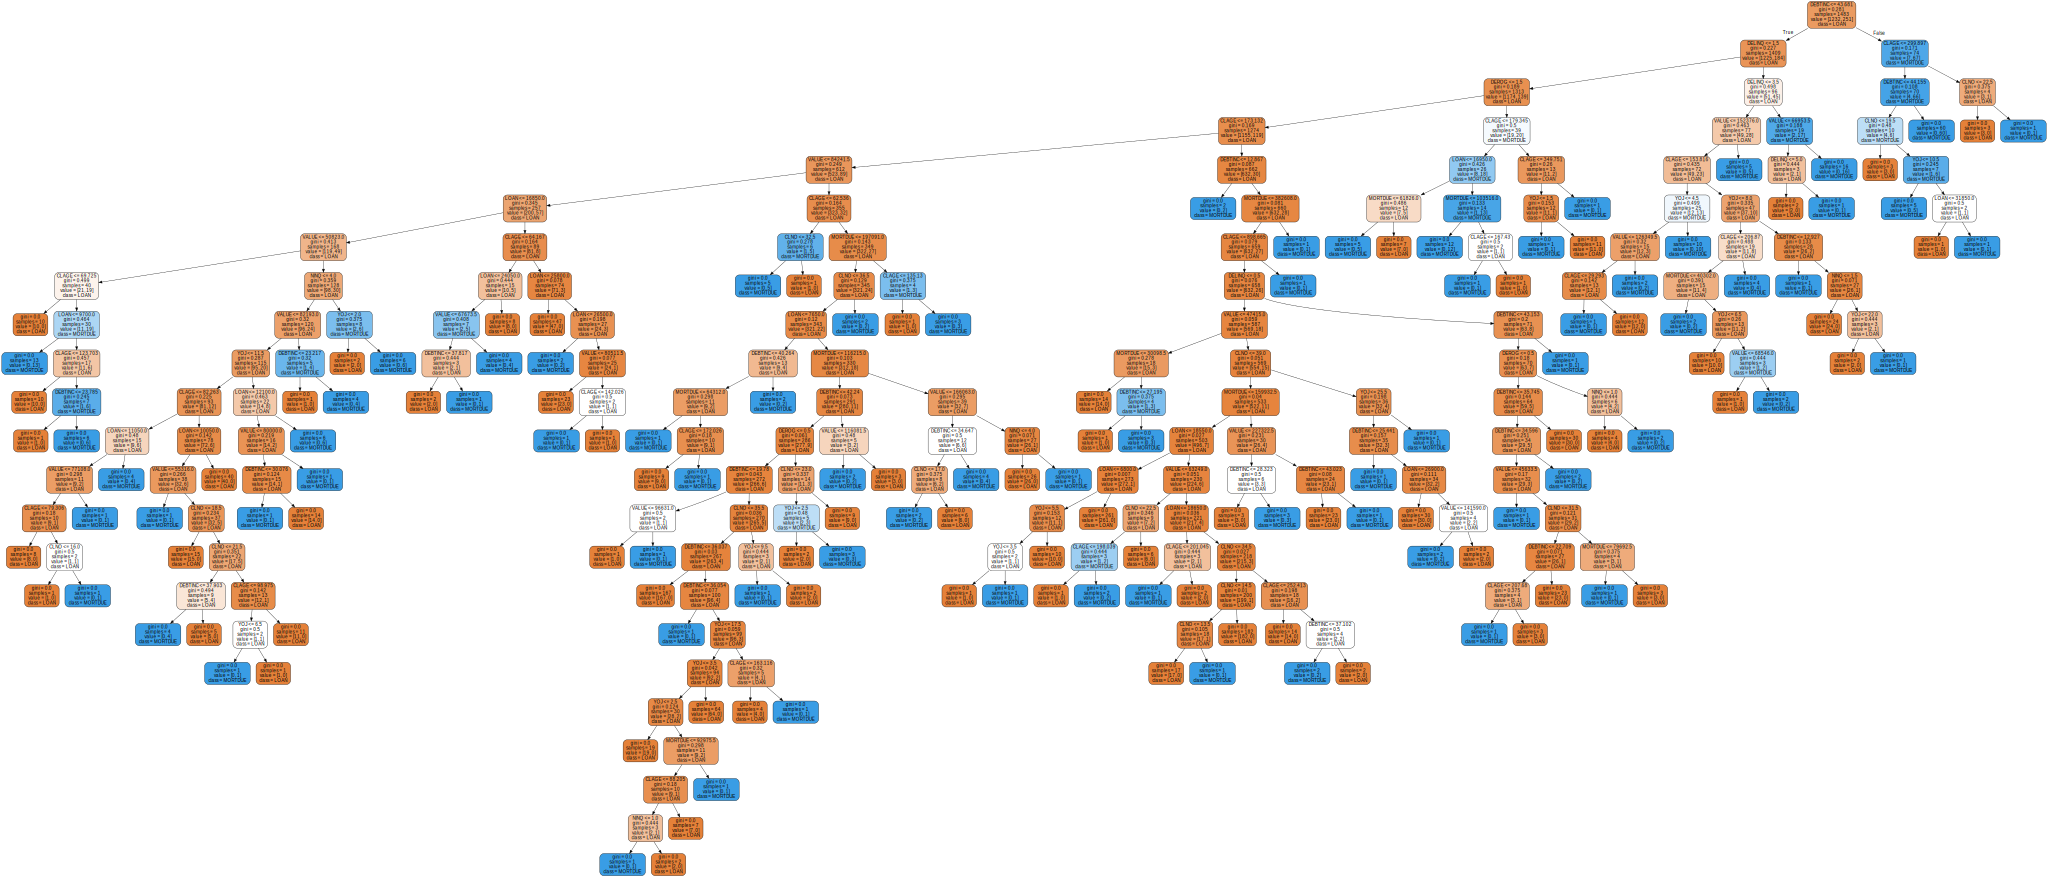

In [34]:
#inspeccionamos el arbol, que resulta muy grande dado que se genera hasta la última hoja
dot_data = tree.export_graphviz(clf_TREE_1, out_file=None, 
  feature_names=['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC'],  
  class_names=['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC'],  
  filled=True, rounded=True
  )

graph = graphviz.Source(dot_data)
graph

<font color='MediumBlue'><strong>
EVALUACION CON METRICAS DEL CONJUNTO DE ENTRENAMIENTO

In [35]:
#Reporte de Clasificación
print(classification_report(y_train, y_train_pred_TREE_1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1232
           1       1.00      1.00      1.00       251

    accuracy                           1.00      1483
   macro avg       1.00      1.00      1.00      1483
weighted avg       1.00      1.00      1.00      1483



<font color='MediumBlue'><strong>
MATRIZ DE CONFUSIÓN PARA EL CONJUNTO DE ENTRENAMIENTO

In [36]:
cm=confusion_matrix(y_train, y_train_pred_TREE_1)
cm

array([[1232,    0],
       [   0,  251]])

[Text(30.5, 0.5, 'Etiqueta predicha'), Text(0.5, 21.5, 'Etiqueta correcta')]

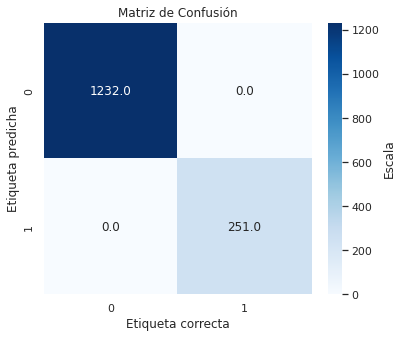

In [37]:
sns.set(color_codes=True)
plt.figure(1, figsize=(6, 5))

plt.title("Matriz de Confusión" )
# define labels
labels = ["0", "1"] 
sns.set(font_scale=1)
ax = sns.heatmap(cm.T, annot=True, fmt='.1f', cmap="Blues", cbar_kws={'label': 'Escala'})
 
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
 
ax.set(ylabel="Etiqueta predicha", xlabel="Etiqueta correcta")

<font color='MediumBlue'><strong>
EVALUACION CON METRICAS DEL CONJUNTO DE EVALUACION

In [38]:
#Reporte de Clasificación 
print(classification_report(y_test, y_test_pred_TREE_1))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       313
           1       0.62      0.64      0.63        58

    accuracy                           0.88       371
   macro avg       0.77      0.78      0.78       371
weighted avg       0.88      0.88      0.88       371



<font color='MediumBlue'><strong>
MATRIZ DE CONFUSIÓN PARA EL CONJUNTO DE EVALUACIÓN

In [39]:
cm2=confusion_matrix(y_test, y_test_pred_TREE_1)
cm2

array([[290,  23],
       [ 21,  37]])

[Text(30.5, 0.5, 'Etiqueta predicha'), Text(0.5, 21.5, 'Etiqueta Correcta')]

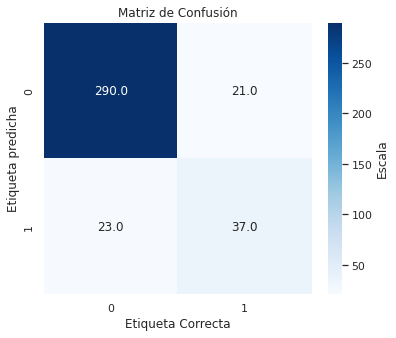

In [40]:
sns.set(color_codes=True)
plt.figure(1, figsize=(6, 5))

plt.title("Matriz de Confusión" )
# define labels
labels = ["0", "1"] 
sns.set(font_scale=1)
ax = sns.heatmap(cm2.T, annot=True, fmt='.1f', cmap="Blues", cbar_kws={'label': 'Escala'})
 
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
 
ax.set(ylabel="Etiqueta predicha", xlabel="Etiqueta Correcta")

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

DecisionTreeClassifier requiere que GridSearchCV optimice dos parámetros, 'criterio' y 'max_ depth', de los cuales GridSearchCV seleccionará el mejor valor

In [41]:
#Grilla de parámetros
param_grid = {
    'criterion': ['gini', 'entropy'],   #criterio de partición
    'max_depth': [2,4,6,8,10],   #profundidad máxima del arbol
    'min_samples_leaf': [1,2,3],    #cantidad minima de samples por hoja
}
# for params in ParameterGrid(param_grid):
#     print(params)
print(f'Combinaciones posibles: {len(ParameterGrid(param_grid))}')

Combinaciones posibles: 30


In [42]:
#Búsqueda de la mejor combinación de parámetros
modelo = DecisionTreeClassifier(random_state=0)
grid_cv = GridSearchCV(modelo, param_grid, scoring='accuracy', cv=5)
grid_cv.fit(X,y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 3]},
             scoring='accuracy')

In [43]:
#Resultados
resultados = pd.DataFrame(grid_cv.cv_results_)[['param_criterion','param_max_depth','param_min_samples_leaf','mean_test_score','std_test_score','rank_test_score']]
resultados.rename_axis('index').sort_values(by = ['rank_test_score', 'index'], ascending = [True, True]).head(10)

,param_criterion,param_max_depth,param_min_samples_leaf,mean_test_score,std_test_score,rank_test_score
index,,,,,,
10,gini,8,2,0.877568,0.022623,1
9,gini,8,1,0.877029,0.019067,2
0,gini,2,1,0.874871,0.010243,3
1,gini,2,2,0.874871,0.010243,3
2,gini,2,3,0.874871,0.010243,3
11,gini,8,3,0.874335,0.020449,6
4,gini,4,2,0.873261,0.026738,7
20,entropy,4,3,0.872714,0.014254,8
3,gini,4,1,0.872180,0.025725,9


In [44]:
#Obtenemos la mejor combinación de parámetros
best_p= grid_cv.best_params_
best_p

{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2}

In [45]:
clf_TREE_2 = DecisionTreeClassifier(**best_p, random_state=0)
clf_TREE_2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=2, random_state=0)

In [46]:
y_test_pred_TREE_2 = clf_TREE_2.predict(X_test)
y_train_pred_TREE_2= clf_TREE_2.predict(X_train)

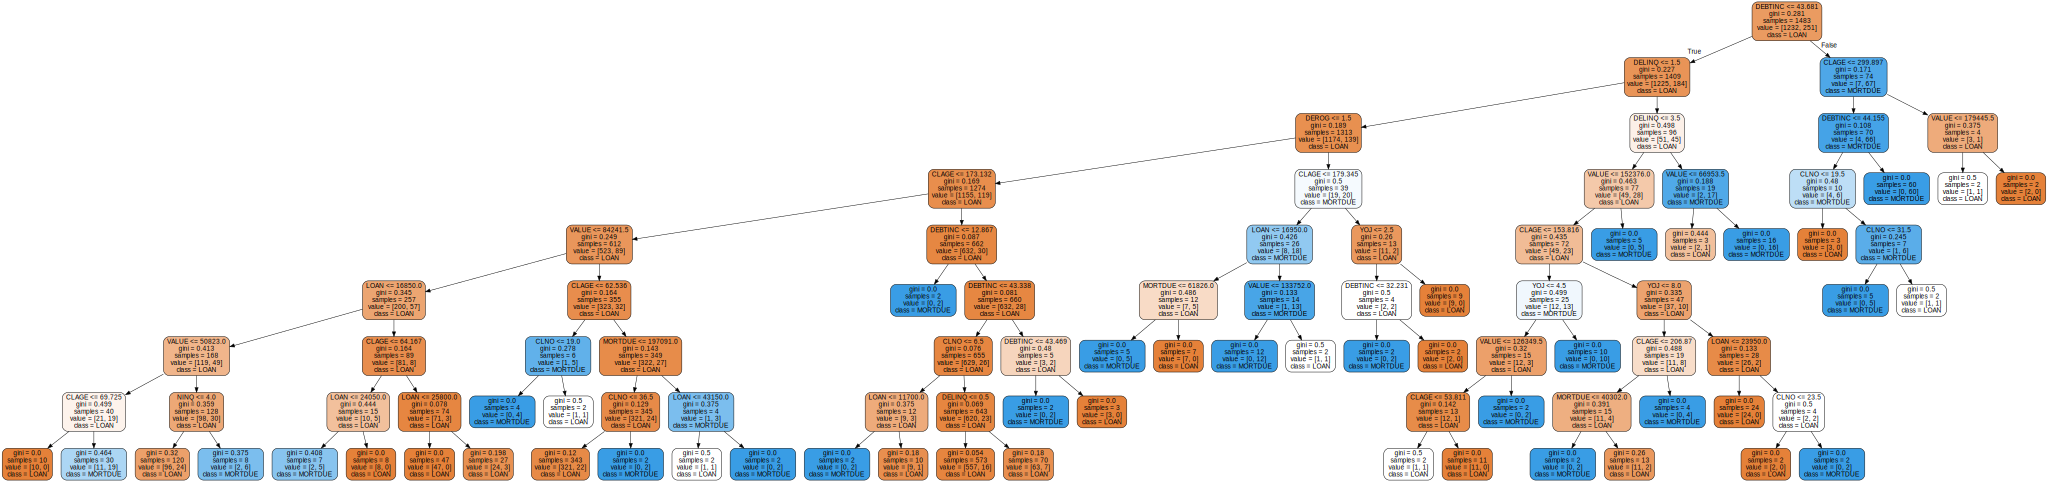

In [47]:
#inspeccionamos el arbol, que tiene una profundidad de 8
dot_data = tree.export_graphviz(clf_TREE_2, out_file=None, 
  feature_names=['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC'],  
  class_names=['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC'],  
  filled=True, rounded=True
  )

graph = graphviz.Source(dot_data)
graph

<font color='MediumBlue'><strong>
EVALUACION CON METRICAS DEL CONJUNTO DE ENTRENAMIENTO

In [48]:
#Reporte de Clasificación
print(classification_report(y_train, y_train_pred_TREE_2))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1232
           1       0.92      0.67      0.78       251

    accuracy                           0.93      1483
   macro avg       0.93      0.83      0.87      1483
weighted avg       0.93      0.93      0.93      1483



<font color='MediumBlue'><strong>
MATRIZ DE CONFUSIÓN PARA EL CONJUNTO DE ENTRENAMIENTO

In [49]:
cm=confusion_matrix(y_train, y_train_pred_TREE_2)
cm

array([[1217,   15],
       [  82,  169]])

[Text(30.5, 0.5, 'Etiqueta predicha'), Text(0.5, 21.5, 'Etiqueta Correcta')]

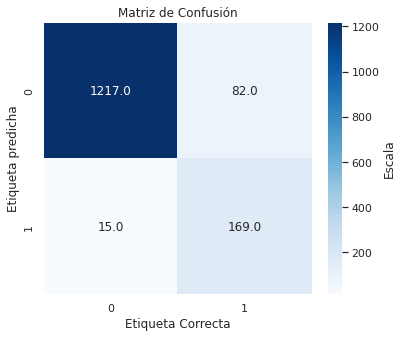

In [50]:
sns.set(color_codes=True)
plt.figure(1, figsize=(6, 5))

plt.title("Matriz de Confusión" )
# define labels
labels = ["0", "1"] 
sns.set(font_scale=1)
ax = sns.heatmap(cm.T, annot=True, fmt='.1f', cmap="Blues", cbar_kws={'label': 'Escala'})
 
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
 
ax.set(ylabel="Etiqueta predicha", xlabel="Etiqueta Correcta")

<font color='MediumBlue'><strong>
EVALUACION CON METRICAS DEL CONJUNTO DE EVALUACION

In [51]:
#Reporte de Clasificación
print(classification_report(y_test, y_test_pred_TREE_2))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       313
           1       0.60      0.48      0.53        58

    accuracy                           0.87       371
   macro avg       0.75      0.71      0.73       371
weighted avg       0.86      0.87      0.86       371



<font color='MediumBlue'><strong>
MATRIZ DE CONFUSIÓN PARA EL CONJUNTO DE EVALUCION

In [52]:
cm2=confusion_matrix(y_test, y_test_pred_TREE_2)
cm2

array([[294,  19],
       [ 30,  28]])

[Text(30.5, 0.5, 'Etiqueta predicha'), Text(0.5, 21.5, 'Etiqueta Correcta')]

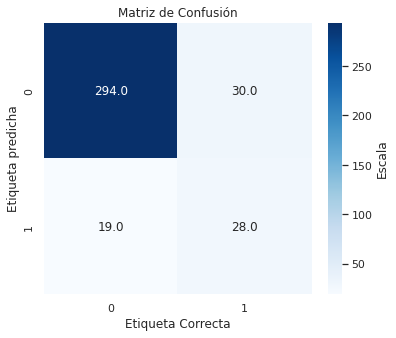

In [53]:
sns.set(color_codes=True)
plt.figure(1, figsize=(6, 5))

plt.title("Matriz de Confusión" )
# define labels
labels = ["0", "1"] 
sns.set(font_scale=1)
ax = sns.heatmap(cm2.T, annot=True, fmt='.1f', cmap="Blues", cbar_kws={'label': 'Escala'})
 
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
 
ax.set(ylabel="Etiqueta predicha", xlabel="Etiqueta Correcta")

<font color='MediumBlue'><strong>
Pese a que el modelo con los parámetros por defecto arroja métricas ligeramente mejores que el modelo con la mejor combinación de parámetros, entendemos que el segundo modelo es superior porque las métricas son similares pero con menor consumo de recursos; y resulta en un modelo menos complejo.<br>
Por último, entre los modelos del descenso por gradiente y el de árbol de decisión, seleccionaríamos como mejor modelo al de descenso de gradiente debido a que la exactitud es mayor, siendo esto de relevancia al momento de otorgar los créditos.